In [1]:
# this is to make the Jupyter notebook as wide as the screen (on the Mac at least) #
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format ='retina'


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import signal as sg
from datetime import datetime as dt
import xarray as xr

In [3]:
def prcrng(x):
    return (np.nanpercentile(x,84) - np.nanpercentile(x,16))/2.

In [4]:
dir_acs = "/users/rsg/spa/spapapers/Pardo_Globlal_Chla/insitu/reprocessing/netCDF/Graban2020/"
fn_acs = "TAO2012.nc"

In [5]:
# read ACS (and HPLC) data in xr format
acs = xr.open_dataset(dir_acs + fn_acs)

# check keys
print(acs.keys())

#check attributes
acs['acs_chl'].attrs

# no of samples
print('No. of HPLC samples= ' + str(len(acs.hplc_time)))
print('No of ACS samples= ' + str(len(acs.time)))

KeysView(<xarray.Dataset>
Dimensions:         (time: 1702, hplc_time: 138, acs_wv: 176)
Coordinates:
  * time            (time) datetime64[ns] 2012-05-09T15:45:26 ... 2012-06-18T...
  * hplc_time       (hplc_time) datetime64[ns] 2012-05-08T07:35:00 ... 2012-0...
  * acs_wv          (acs_wv) float64 400.0 402.0 404.0 ... 746.0 748.0 750.0
Data variables:
    hplc_lat        (hplc_time) float64 ...
    hplc_lon        (hplc_time) float64 ...
    hplc_Tot_Chl_a  (hplc_time) float64 ...
    uway_lat        (time) float64 ...
    uway_lon        (time) float64 ...
    acs_chl         (time) float64 ...
    acs_ap          (time, acs_wv) float64 ...)
No. of HPLC samples= 138
No of ACS samples= 1702


['2012-05-09T15:45:26.000000000' '2012-05-09T16:15:26.000000000'
 '2012-05-09T16:30:26.000000000' ... '2012-06-18T15:31:26.000000000'
 '2012-06-18T15:46:27.000000000' '2012-06-18T16:46:32.000000000']


Text(0, 0.5, 'lon')

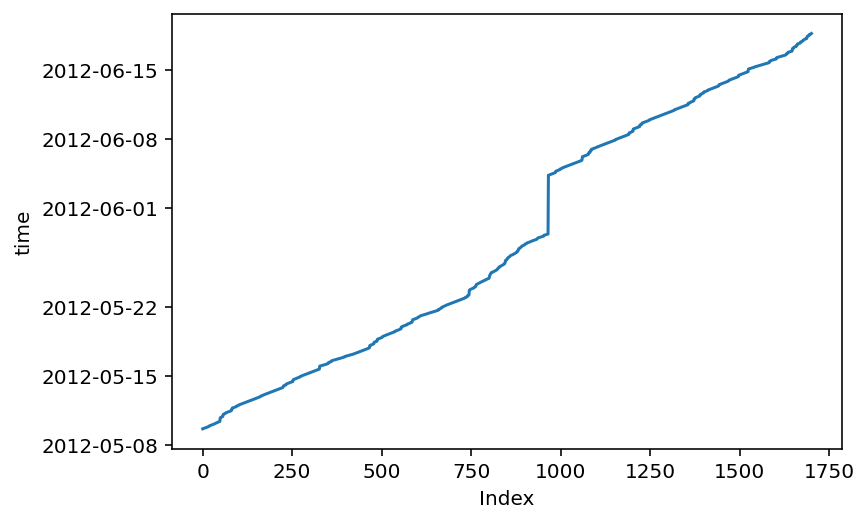

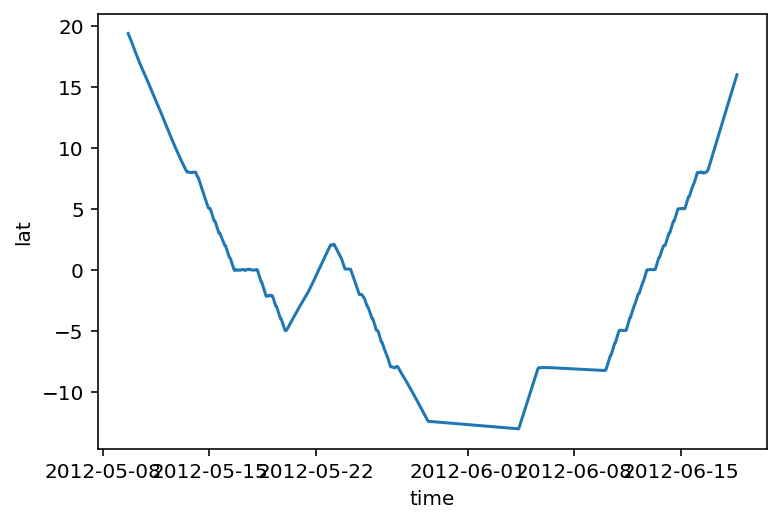

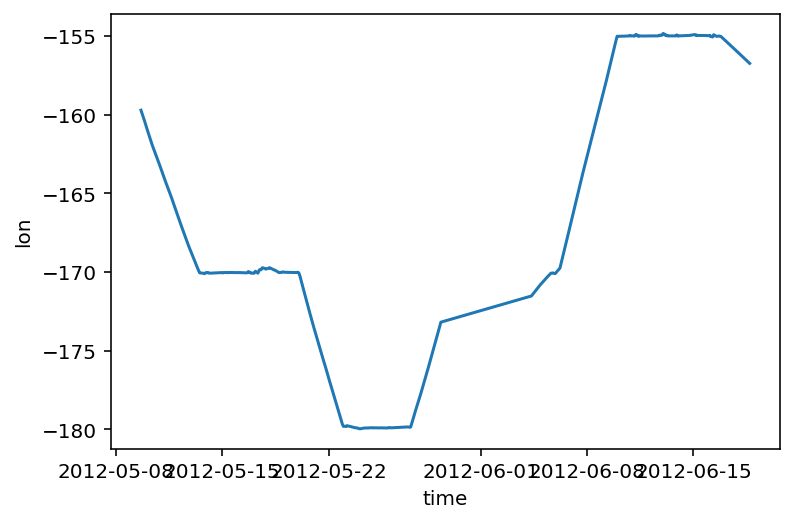

In [6]:
# check time, lat, lon
plt.rcParams.update({'font.size': 9})
    
plt.figure()
plt.plot(acs.time)
plt.xlabel('Index')
plt.ylabel('time')
print(acs.time.values)

plt.figure()
plt.plot(acs.time, acs.uway_lat)
plt.xlabel('time')
plt.ylabel('lat')

plt.figure()
plt.plot(acs.time, acs.uway_lon)
plt.xlabel('time')
plt.ylabel('lon')

# repeat time indicies are present - must remove

In [8]:
# check temporal sample rate
plt.figure()
delta_t = np.median(np.diff(acs.time))
print(delta_t)
print(str(int(delta_t/10**9)) + ' secs')

# == ~ 15 min. Too course for median filter for TAO2012 -

902000000000 nanoseconds
902 secs


<Figure size 432x288 with 0 Axes>

['hplc_lat', 'hplc_lon', 'hplc_Tot_Chl_a', 'uway_lat', 'uway_lon', 'acs_chl', 'acs_ap']


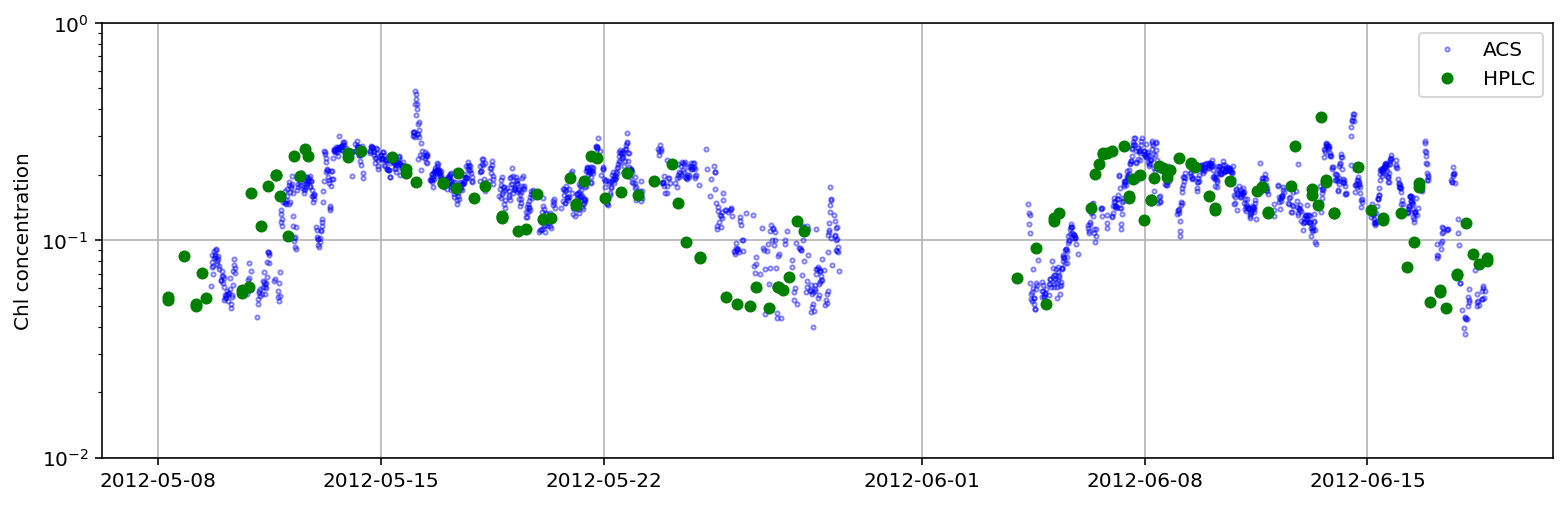

In [12]:
# Test plot of ACS(9) and HPLC Chl prior to match-up
# include emprical adjustment of AC9 chl using AMT
MEDFILT_WIN = 1 # window length of med filter in minutes - note: this assumes data has been binned at 1 minute

#
fig2, ax2 = plt.subplots(1, figsize=(13, 4))
ax2.semilogy(acs.time, sg.medfilt(acs.acs_chl, kernel_size=MEDFILT_WIN), 'bo', lw=1, ms=2, mfc='none', alpha = 0.5, label='ACS')
ax2.grid('on')
plt.legend()
plt.ylim([1e-2, 1])
plt.ylabel('Chl concentration')

#
print(list(acs.keys()))
ax2.semilogy(acs.hplc_time, acs.hplc_Tot_Chl_a, 'go', ms=5, alpha=1, label='HPLC')#, mfc='none')
# a2.semilogy(df_CTD.index, df_CTD.Tot_Chl_a, 'ko', ms=7, alpha=1, mfc='none', zorder=60)
# ax2.scatter(df_CTD.index, df_CTD.Tot_Chl_a, c=df_CTD.Bottle.values, s=30, alpha=1, zorder=60, cmap = plt.get_cmap('inferno'), vmin=2, vmax=24)
# ax2.semilogy(df_UND.index, df_UND.Tot_Chl_a, 'ks', ms=7, alpha=0.85, mfc='c')
plt.legend()
#########


In [51]:
# maybe hplc lags by 1 day?
#for i in range(len(acs['hplc_time'])):
 #      acs['hplc_time'][i] = acs['hplc_time'][i] +  np.timedelta64(1,'D') 

1702
1702


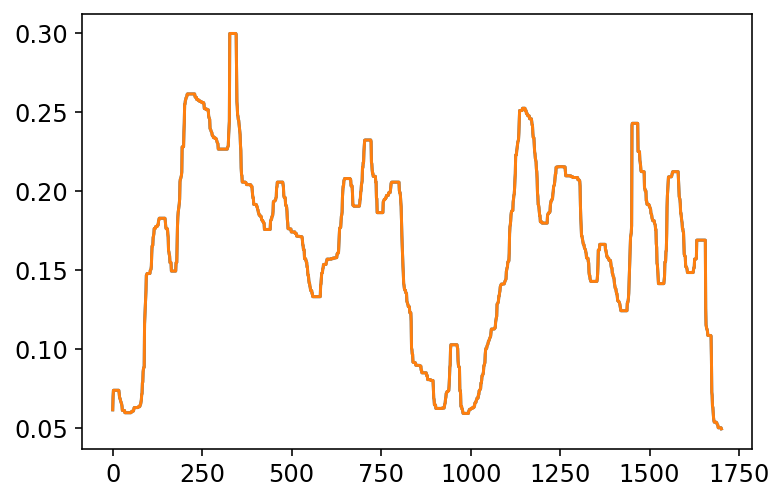

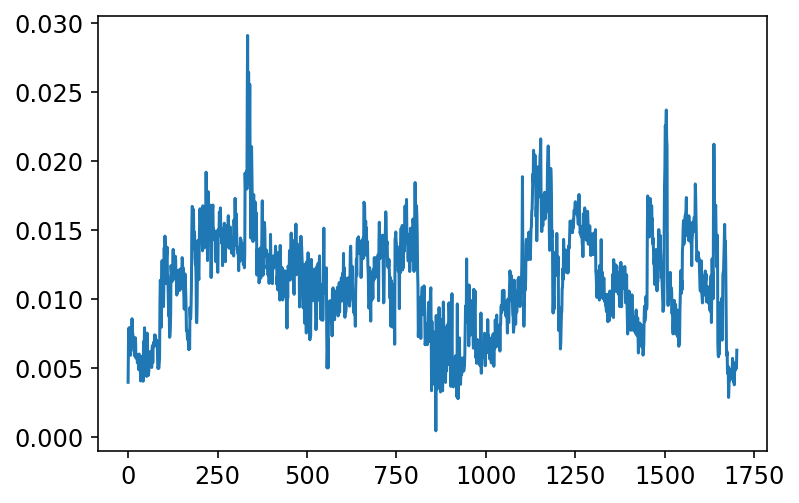

In [40]:
# step x - # median filter
plt.figure()
acs['acs_chl'].values = sg.medfilt(acs.acs_chl, kernel_size = MEDFILT_WIN) # apply med filter to acx chl and acx chl debiasesd 
plt.plot(acs['acs_chl'].values)

# step y  #filters w.r.t. ap(420) (10th element) being > 0
i2kp = np.where((acs.acs_ap[:,10] > 0)) [0]
iy = xr.DataArray(acs.time[i2kp], dims=['time']) 
acs_y = acs.sel(time = iy)
plt.plot(acs_y['acs_chl'].values)
print(len(acs_y['acs_chl'].values))

#step z - # filters w.r.t. acs chl being > 0
i2kp = np.where((acs_y.acs_chl[:] > 0)) [0]
iz = xr.DataArray(acs_y.time[i2kp], dims=['time']) 
acs_z = acs_y.sel(time = iz)
print(len(acs_z['acs_chl'].values))

# for NAAMES 2 - data looks to have already had effective QC
plt.figure()
plt.plot(acs.acs_ap[:,10])

In [41]:
acs = []
acs = acs_z # redefine as filtered data structure

In [42]:
# match-ups #

# creat seriers objects
df_hplc = pd.Series(acs['hplc_Tot_Chl_a'].values,index = acs.hplc_time)
df_acs = pd.Series(acs['acs_chl'].values, index = acs.time)

# filter replicate hplcs
df_hplc = df_hplc.groupby(df_hplc.index).mean().reindex()

#
# creat seriers objects
df_hplc = pd.Series(acs['hplc_Tot_Chl_a'].values ,index = acs.hplc_time)
df_acs = pd.Series(acs['acs_chl'].values, index = acs.time)

# filter
df_hplc = df_hplc.groupby(df_hplc.index).mean() 
df_acs = df_acs.groupby(df_acs.index).mean() 

df_hplc_acs = pd.DataFrame({'Tot_Chl_a': df_hplc, 'acs_chl': df_acs})
#df_hplc_acs = df_hplc_acs.interpolate('index',limit=1).reindex(df_hplc_acs.index,method='nearest',tolerance='30min')
df_hplc_acs = df_hplc_acs.interpolate('index').reindex(df_hplc.index,method='nearest',tolerance='30min')

In [43]:
print(df_hplc_acs)
# nans in acs_ch are where there are no match-ups

                     Tot_Chl_a   acs_chl
2012-05-08 07:35:00     0.0540       NaN
2012-05-08 19:36:00     0.0850       NaN
2012-05-09 04:25:00     0.0505       NaN
2012-05-09 08:45:00     0.0710       NaN
2012-05-09 12:03:00     0.0540       NaN
...                        ...       ...
2012-06-17 19:54:00     0.0695  0.108615
2012-06-18 02:19:00     0.1200  0.053767
2012-06-18 07:38:00     0.0860  0.052822
2012-06-18 12:09:00     0.0780  0.050233
2012-06-18 18:22:00     0.0815  0.049561

[110 rows x 2 columns]


Linear metrics
0.03179091838678483 0.46408087930197184 105
Log metrics
-0.016235933753063314 0.2658355481239835 105


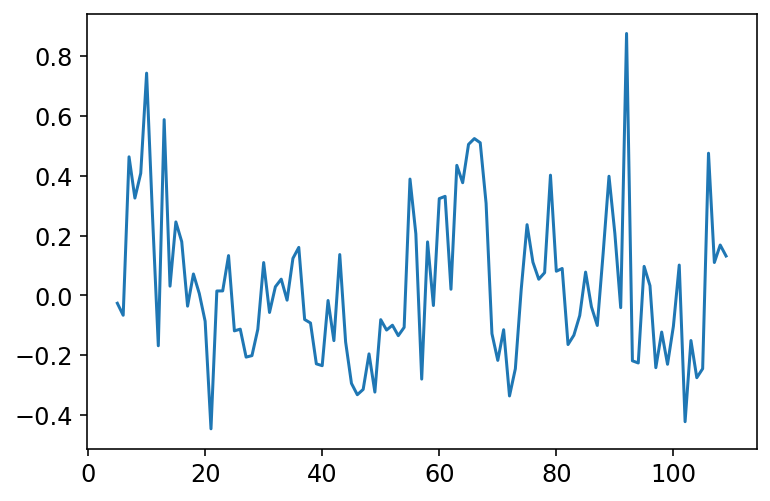

In [27]:
# compute residuals (lin and log space)
rres = df_hplc_acs.acs_chl.values / df_hplc_acs.Tot_Chl_a.values - 1
rres_log = np.log10(df_hplc_acs.acs_chl.values)/ np.log10(df_hplc_acs.Tot_Chl_a.values) - 1

delta = np.nanmedian(rres)
delta_log = np.nanmedian(rres_log)
sigma = prcrng(rres)
sigma_log = prcrng(rres_log)
N = np.sum(~np.isnan(rres))
N_log = np.sum(~np.isnan(rres_log))

print('Linear metrics')
print(delta, sigma, N)

print('Log metrics')
print(delta_log, sigma_log, N)

plt.figure()
plt.plot(rres_log)


['hplc_lat', 'hplc_lon', 'hplc_Tot_Chl_a', 'uway_lat', 'uway_lon', 'acs_chl', 'acs_ap']


/tmp/ipykernel_290135/2504834762.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  ax2.semilogy(df_hplc.index, df_hplc.values, 'go', ms=5, color='green', alpha=1, label='HPLC_all')#, mfc='none')
/tmp/ipykernel_290135/2504834762.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  ax2.semilogy(df_hplc_acs.index[~np.isnan(rres)==1], df_hplc_acs.Tot_Chl_a[~np.isnan(rres)==1], 'go', ms=5, color='red', alpha=1, label='HPLC matches')#, mfc='none')


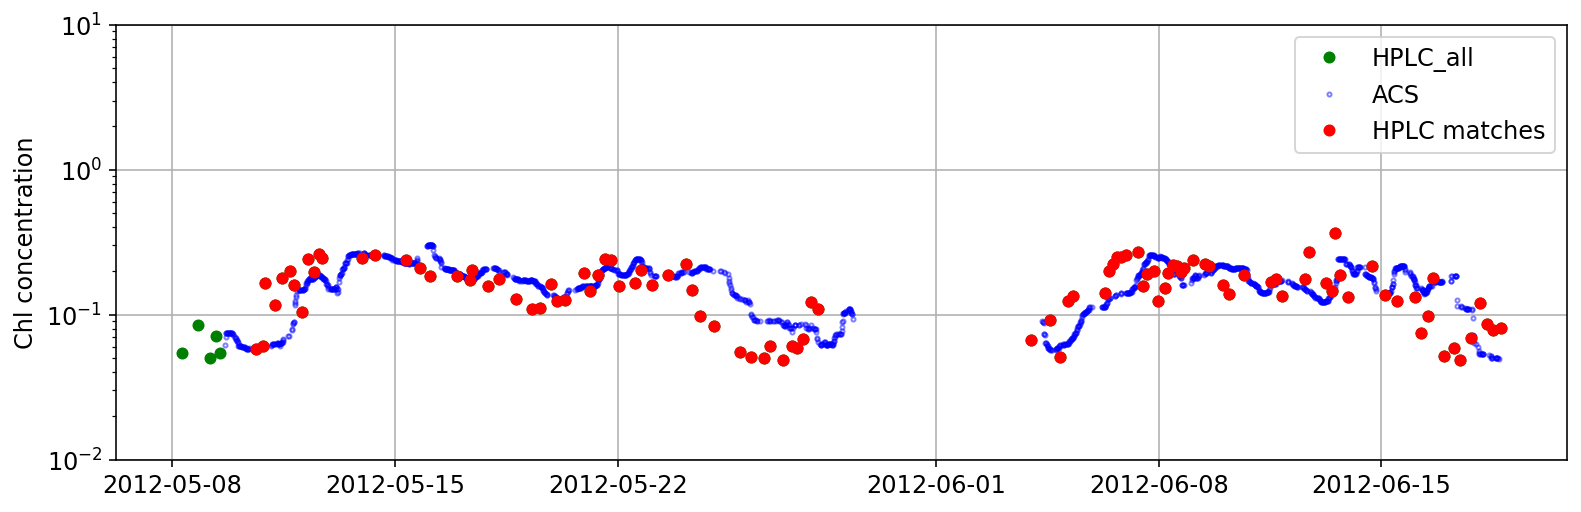

In [30]:
# Test plot of ACS(9) and HPLC Chl post match-up


MEDFILT_WIN = 31 # window length of med filter in minutes - note: this assumes data has been binned at 1 minute. 

#
fig2, ax2 = plt.subplots(1, figsize=(13, 4))
ax2.semilogy(df_hplc.index, df_hplc.values, 'go', ms=5, color='green', alpha=1, label='HPLC_all')#, mfc='none')
ax2.semilogy(acs.time, sg.medfilt(acs.acs_chl, kernel_size=MEDFILT_WIN), 'bo', lw=1, ms=2, mfc='none', alpha = 0.5, label='ACS')
ax2.grid('on')
plt.legend()
plt.ylim([1e-2, 10])
plt.ylabel('Chl concentration')

print(list(acs.keys()))
ax2.semilogy(df_hplc_acs.index[~np.isnan(rres)==1], df_hplc_acs.Tot_Chl_a[~np.isnan(rres)==1], 'go', ms=5, color='red', alpha=1, label='HPLC matches')#, mfc='none')
plt.legend()
#########




In [31]:
+
# scatter plots
plt.rcParams.update({'font.size': 12})
    
fig, ax = plt.subplots(1,2, figsize=(12, 4))

ax[0].loglog(df_hplc_acs.Tot_Chl_a.values, df_hplc_acs.acs_chl.values, 'o', ms=4, alpha=0.25)
x = np.logspace(np.log10(0.01), np.log10(10), 100)
ax[0].loglog(x, x, 'r-', lw=1)
ax[0].grid('on', ls='--')
ax[0].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[0].set_ylabel('ACs Chl_a [mg/m3]', fontweight='bold')

ax[1].semilogx(df_hplc_acs.Tot_Chl_a.values, rres, 'o', ms=4, alpha=0.25)
ax[1].semilogx(x, x*0, 'r-', lw=1)
ax[1].grid('on', ls='--')
ax[1].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[1].set_ylabel('$\delta$', fontweight='bold')
ax[1].set_ylim([-1, 1])
ax[1].text(1.2, 0.8, r'$\delta$='+f'{delta:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.7, r'$\sigma$='+f'{sigma:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.6, r'$\delta_{log10}$='+f'{delta_log:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.5, r'$\sigma_{log10}$='+f'{sigma_log:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.4, f'N = {N: 0}', fontweight='bold')




print(df_hplc_acs.Tot_Chl_a.values)



SyntaxError: invalid syntax (4013876423.py, line 1)

(-1.0, 1.0)

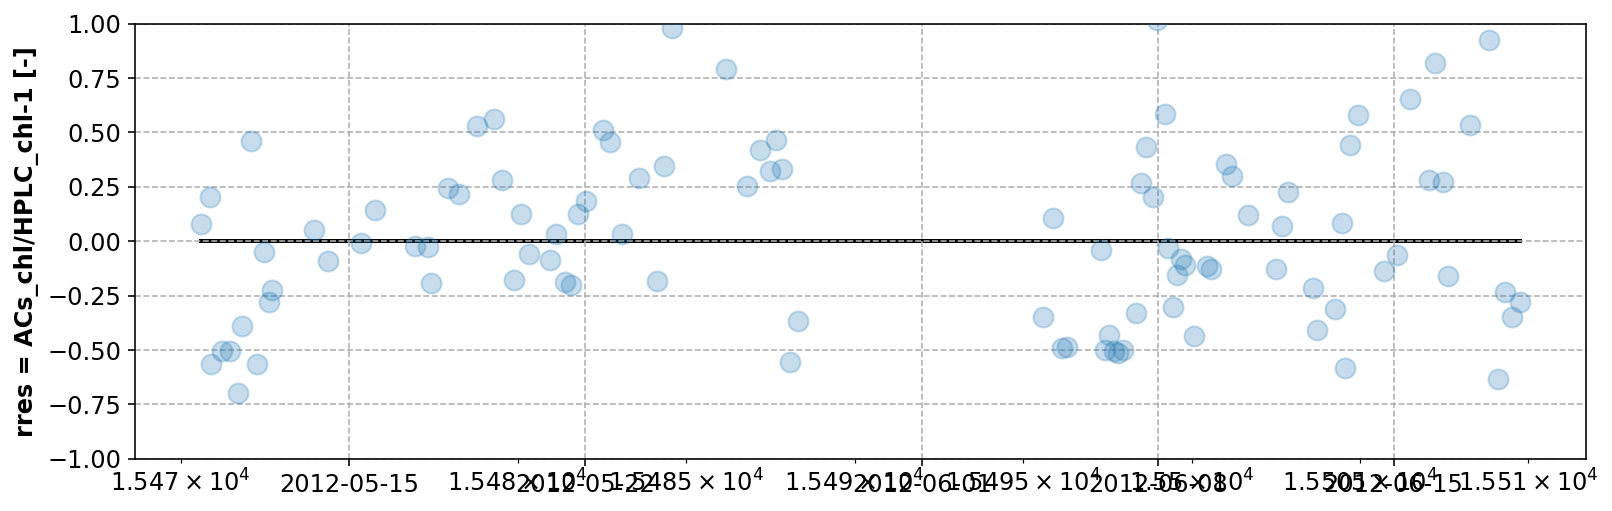

In [32]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.semilogx(df_hplc_acs.index.values, rres, 'o', ms=10, alpha=0.25, zorder=60)
ax.plot(df_hplc_acs.index.values, rres*0, 'k-', lw=2, zorder=1)
ax.set_ylabel('rres = ACs_chl/HPLC_chl-1 [-]', fontweight='bold')
ax.grid('on', ls='--')
ax.set_ylim([-1, 1])

In [33]:
# Apply log transform prior to fitting power-law. Notation follows Brewin 2016. 
import scipy

linear_mod = scipy.stats.linregress(np.log10(0.014*df_hplc_acs.acs_chl.values[~np.isnan(rres)==1]), np.log10(df_hplc_acs.Tot_Chl_a.values[~np.isnan(rres)==1]))

A = np.round(100*linear_mod.intercept)/100
B = np.round(1000*linear_mod.slope)/1000
r_sq = np.round(1000*linear_mod.rvalue**2)/100

r_sq = np.round(1000*linear_mod.rvalue**2)/1000
stderr = np.round(1000*linear_mod.stderr)/1000
interr = np.round(1000*linear_mod.intercept_stderr)/1000

print('A = ' + str(10**A) + ' +/- ' + str(2*10**interr))
print('B = ' + str(B) + ' +/- ' + str(2*stderr))
print('r_sq = ' + str(r_sq))

A = 4.073802778041127 +/- 3.4996933772493137
B = 0.54 +/- 0.18
r_sq = 0.261


In [34]:
# de-bias ACS-chl following eq 3 in Graban et al., 2020 (https://doi.org/10.1364/OE.397863)
acs['acs_chl_debiased'] = acs.acs_chl*(1-delta)
# acs_out = pd.DataFrame(data = {'lat [degN]': acs.uway_lat[i2f][innan],
#                              'lon [degE]': acs.uway_lon[i2f][innan],
#                             'acs_chl_debiased [mg_m3]': acs.acs_chl_debiased[i2f][innan]
#                           }  ,
# index = acs.time.values[i2f][innan])

In [35]:
# add attributes to acs_chl_debiased #
acs.acs_chl_debiased.attrs["debiasing_equation"] = "acs.acs_chl_debiased = acs.acs_chl*(1-delta)"
acs.acs_chl_debiased.attrs["delta"] = delta
acs.acs_chl_debiased.attrs["sigma"] = sigma
acs.acs_chl_debiased.attrs["units"] = "mg/m3"
acs.acs_chl_debiased.attrs["comments"] = "delta=np.nanmedian(rres), sigma=prcrng(rres), rres=acs_chl/HPLC_Tot_Chl_a-1, based on surface data"
acs.acs_chl_debiased.attrs["HPLC_Tot_chla"] = df_hplc_acs.Tot_Chl_a[~np.isnan(rres)==1].values  # filter nans
acs.acs_chl_debiased.attrs["HPLC_Tot_chla_units"] = "mg/m3"
acs.acs_chl_debiased.attrs["acs_chl"] = df_hplc_acs[~np.isnan(rres)==1].acs_chl.values # filter nans
acs.acs_chl_debiased.attrs["acs_chl_units"] = "mg/m3"
acs.acs_chl_debiased.attrs["processed_on"] = dt.now().strftime("%Y-%m-%d %H:%M:%S.%f")
acs.acs_chl_debiased.attrs["match_up_dates"] = df_hplc_acs[~np.isnan(rres)==1].index.format()

In [36]:

print(acs.acs_chl_debiased)
len(acs.acs_chl_debiased.attrs["match_up_dates"])
len(acs.acs_chl_debiased.attrs["HPLC_Tot_chla"])


<xarray.DataArray 'acs_chl_debiased' (time: 1702)>
array([0.05963583, 0.07248977, 0.0831307 , ..., 0.05851853, 0.05229851,
       0.05674668])
Coordinates:
  * time     (time) datetime64[ns] 2012-05-09T15:45:26 ... 2012-06-18T16:46:32
Attributes:
    debiasing_equation:   acs.acs_chl_debiased = acs.acs_chl*(1-delta)
    delta:                0.03179091838678483
    sigma:                0.46408087930197184
    units:                mg/m3
    comments:             delta=np.nanmedian(rres), sigma=prcrng(rres), rres=...
    HPLC_Tot_chla:        [0.058  0.061  0.165  0.116  0.178  0.1995 0.159  0...
    HPLC_Tot_chla_units:  mg/m3
    acs_chl:              [0.06253824 0.07350729 0.07159825 0.05755277 0.0879...
    acs_chl_units:        mg/m3
    processed_on:         2023-11-29 17:01:02.119194
    match_up_dates:       ['2012-05-10 14:47:00', '2012-05-10 20:39:00', '201...


105

In [37]:
print('max/min conc range for results table')
print(np.min(acs.acs_chl_debiased.attrs["HPLC_Tot_chla"]))
print(np.max(acs.acs_chl_debiased.attrs["HPLC_Tot_chla"])) # quote min max of match-ups 

max/min conc range for results table
0.049
0.367


In [38]:

# save updated NetCDF file
dir_acs_out = '/data/datasets/cruise_data/active/ACS_Chl/Glob_OC_matchups/Debiased_nc/'
acs.to_netcdf(dir_acs_out + fn_acs[:-3] + '_with_debiased_chl.nc')
acs.close()
